🔍 Dispositivos disponibles:
0: Microsoft Sound Mapper - Input (inputs: 2)
1: MicrÃ³fono (Steam Streaming Micr (inputs: 8)
2: Auriculares con micrÃ³fono (AirP (inputs: 1)
3: Microsoft Sound Mapper - Output (inputs: 0)
4: Auriculares (AirPods Pro Stereo (inputs: 0)
5: Auriculares (2- High Definition (inputs: 0)
6: Altavoces (Steam Streaming Spea (inputs: 0)
7: Altavoces (Steam Streaming Micr (inputs: 0)
8: Auriculares con micrÃ³fono (AirP (inputs: 0)
9: Controlador primario de captura de sonido (inputs: 2)
10: MicrÃ³fono (Steam Streaming Microphone) (inputs: 8)
11: Auriculares con micrÃ³fono (AirPods Pro Hands-Free AG Audio) (inputs: 1)
12: Controlador primario de sonido (inputs: 0)
13: Auriculares (AirPods Pro Stereo) (inputs: 0)
14: Altavoces (Steam Streaming Speakers) (inputs: 0)
15: Auriculares (2- High Definition Audio Device) (inputs: 0)
16: Altavoces (Steam Streaming Microphone) (inputs: 0)
17: Auriculares con micrÃ³fono (AirPods Pro Hands-Free AG Audio) (inputs: 0)
18: Altavoces 

👉 Ingresa el índice de tu micrófono:  2


🎙️ Grabando...
✅ Grabación terminada
🔊 Reproduciendo...


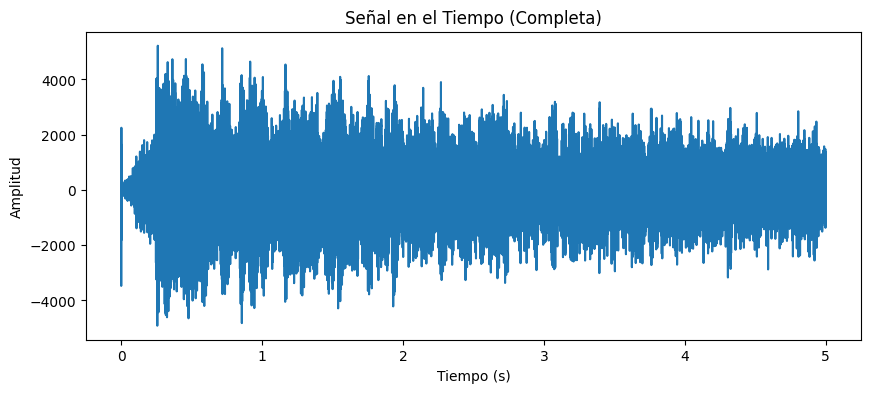

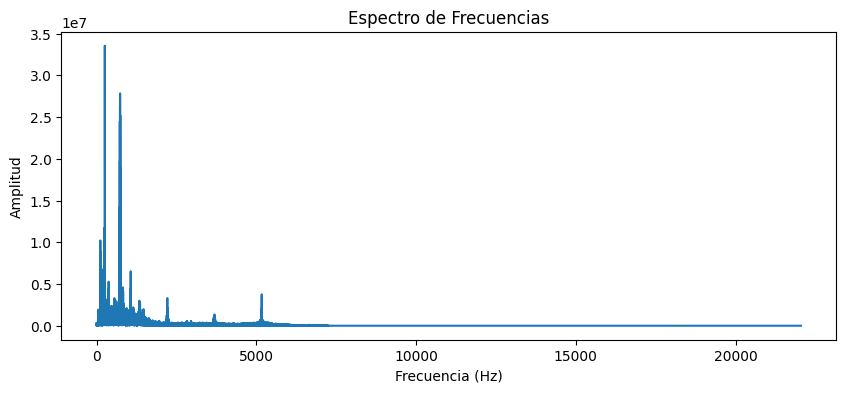


Frecuencia Fundamental: 117.62 Hz (La#2)

Primeros 3 Armónicos:
Armónico | Frecuencia (Hz) | Nota Musical
1         | 117.62 Hz       | La#2
2         | 235.24 Hz       | La#3
3         | 352.86 Hz       | Fa4


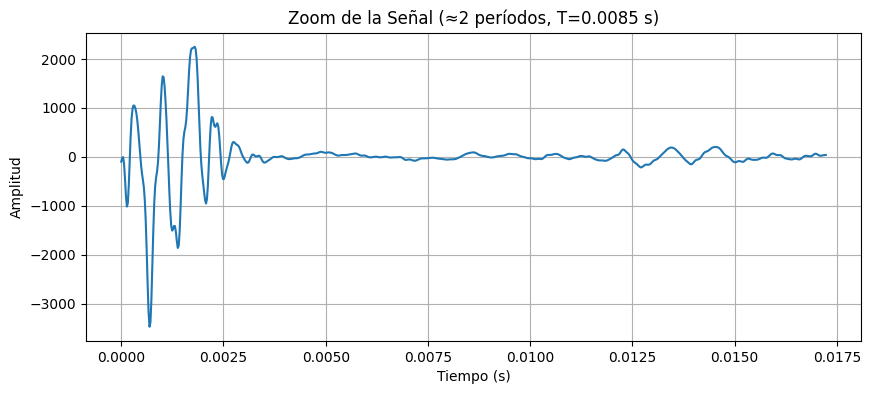

In [8]:
import numpy as np
import pyaudio
import matplotlib.pyplot as plt
from scipy.fftpack import fft
from scipy.signal import find_peaks

# --- Mapeo de notas en sistema latino ---
note_names_latin = {
    "C": "Do", "C#": "Do#", "D": "Re", "D#": "Re#", "E": "Mi", "F": "Fa",
    "F#": "Fa#", "G": "Sol", "G#": "Sol#", "A": "La", "A#": "La#", "B": "Si"
}

def frequency_to_note_latin(freq):
    """Convierte una frecuencia en Hz a nota musical (sistema latino)."""
    A4 = 440.0
    if freq == 0:
        return "N/A"
    semitones = int(round(12 * np.log2(freq / A4)))
    note_index = (semitones + 9) % 12
    octave = 4 + ((semitones + 9) // 12)
    note_en = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"][note_index]
    note_lat = note_names_latin[note_en]
    return f"{note_lat}{octave}"

# --- Parámetros ---
CHUNK = 4096
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 44100
DURATION = 5

# --- Inicializar PyAudio ---
p = pyaudio.PyAudio()

# Mostrar dispositivos disponibles
print("🔍 Dispositivos disponibles:")
for i in range(p.get_device_count()):
    info = p.get_device_info_by_index(i)
    print(f"{i}: {info['name']} (inputs: {info['maxInputChannels']})")

# 👇 cambia este índice según tu micro detectado
device_index = int(input("👉 Ingresa el índice de tu micrófono: "))

stream = p.open(format=FORMAT, channels=CHANNELS,
                rate=RATE, input=True,
                input_device_index=device_index,
                frames_per_buffer=CHUNK)

print("🎙️ Grabando...")
frames = []
for _ in range(0, int(RATE / CHUNK * DURATION)):
    data = stream.read(CHUNK, exception_on_overflow=False)
    frames.append(data)

print("✅ Grabación terminada")
stream.stop_stream()
stream.close()

# --- Reproducir lo grabado ---
print("🔊 Reproduciendo...")
play_stream = p.open(format=FORMAT,
                     channels=CHANNELS,
                     rate=RATE,
                     output=True)

for frame in frames:
    play_stream.write(frame)

play_stream.stop_stream()
play_stream.close()
p.terminate()

# --- Procesar audio ---
audio_data = np.concatenate([np.frombuffer(f, dtype=np.int16) for f in frames])
time = np.linspace(0, DURATION, num=len(audio_data))

# Señal completa
plt.figure(figsize=(10, 4))
plt.plot(time, audio_data)
plt.title("Señal en el Tiempo (Completa)")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.show()

# FFT
yf = fft(audio_data)
yf = np.abs(yf[:len(yf)//2])
xf = np.linspace(0, RATE/2, num=len(yf))

plt.figure(figsize=(10, 4))
plt.plot(xf, yf)
plt.title("Espectro de Frecuencias")
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Amplitud")
plt.show()

# Frecuencia fundamental
peaks, _ = find_peaks(yf, height=np.max(yf)*0.2)
frequencies = xf[peaks]
main_frequency = frequencies[0] if len(frequencies) > 0 else 0
main_note = frequency_to_note_latin(main_frequency)

print(f"\nFrecuencia Fundamental: {main_frequency:.2f} Hz ({main_note})")

# Armónicos
harmonics = [main_frequency * i for i in range(1, 4)]
print("\nPrimeros 3 Armónicos:")
print("Armónico | Frecuencia (Hz) | Nota Musical")
for i, freq in enumerate(harmonics, start=1):
    note = frequency_to_note_latin(freq)
    print(f"{i:<9} | {freq:.2f} Hz       | {note}")

# Zoom en la señal
if main_frequency > 0:
    period = 1 / main_frequency
    zoom_duration = 2 * period
    samples_zoom = int(RATE * zoom_duration)

    plt.figure(figsize=(10, 4))
    plt.plot(time[:samples_zoom], audio_data[:samples_zoom])
    plt.title(f"Zoom de la Señal (≈2 períodos, T={period:.4f} s)")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Amplitud")
    plt.grid(True)
    plt.show()
